<h2>Imports<h2>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from pathlib import Path
from sklearn.impute import KNNImputer
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import PowerTransformer


<p>Reading the document<p>

In [3]:
#Open Excel files with different extensions
filename = 'train.csv'
file_path = Path(filename)
file_extension = file_path.suffix.lower()[1:]

if file_extension == 'xlsx':
    d = pd.read_excel(file_path, engine='openpyxl')
    data = d.copy()
elif file_extension == 'xls':
    d = pd.read_excel(file_path)
    data = d.copy()
elif file_extension == 'csv':
    d = pd.read_csv(file_path, delimiter=";")
    data = d.copy()
else:
    raise Exception("File not supported")


<h3>Data Head<h3>

In [4]:
data.head()

,Cust_ID,Churn,Name,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1,churn,Ms. Nicole Clarke,yes,1974.0,business,single,4907,3,4,...,4,3,4,3,3,3,3,4,3,4
1,2,nochurn,Mr. Jesse Scott,yes,1965.0,business,single,6724,1,1,...,5,3,4,5,5,5,5,1,5,2
2,3,churn,Mr. Christopher Carter,yes,1973.0,business,single,4365,3,3,...,1,4,4,3,3,2,3,2,3,1
3,4,nochurn,Ms. Jennifer Morgan,yes,1993.0,leisure,double,3849,1,1,...,4,4,5,4,4,4,4,4,4,3
4,5,nochurn,Mr. Michael White,yes,1989.0,business,single,5376,2,2,...,5,5,5,5,5,3,4,1,3,5


<h3>Data Info<h3>

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15589 entries, 0 to 15588
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cust_ID            15589 non-null  int64  
 1   Churn              15589 non-null  object 
 2   Name               15589 non-null  object 
 3   Longevity          15589 non-null  object 
 4   Year_Birth         15394 non-null  float64
 5   TypeTravel         15589 non-null  object 
 6   RoomType           15589 non-null  object 
 7   RewardPoints       15589 non-null  int64  
 8   Comfort            15589 non-null  int64  
 9   ReceptionSchedule  15589 non-null  int64  
 10  FoodDrink          15589 non-null  int64  
 11  Location           15589 non-null  int64  
 12  Wifi               15589 non-null  int64  
 13  Amenities          15589 non-null  int64  
 14  Staff              15589 non-null  int64  
 15  OnlineBooking      15589 non-null  int64  
 16  PriceQuality       155

In [6]:
data.shape

(15589, 22)

<h3>Looking for Null values<h3>

<p> By summing the null values for each attribute and then dividing them by the total of values of the same attribute, we will obtain the percentage of null values that each column has. A value different from 0 means that the column has 1 or more missing values, which is not desired. </p>

In [7]:
data.isna().sum()/len(data)*100

Cust_ID              0.000000
Churn                0.000000
Name                 0.000000
Longevity            0.000000
Year_Birth           1.250882
TypeTravel           0.000000
RoomType             0.000000
RewardPoints         0.000000
Comfort              0.000000
ReceptionSchedule    0.000000
FoodDrink            0.000000
Location             0.000000
Wifi                 0.000000
Amenities            0.000000
Staff                0.000000
OnlineBooking        0.000000
PriceQuality         0.000000
RoomSpace            0.000000
CheckOut             0.000000
Checkin              0.000000
Cleanliness          0.000000
BarService           0.000000
dtype: float64

<h3> Find outliers in Year_Birth <h3>

<AxesSubplot:xlabel='Year_Birth', ylabel='Count'>

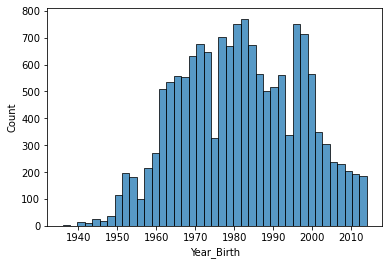

In [8]:
sns.histplot(data=data, x='Year_Birth')

<h3> Power Transformation for Reward Points <h3>

<p>We will now apply a power transformation to make data more Gaussian-like.</p>

<AxesSubplot:xlabel='RewardPoints', ylabel='Count'>

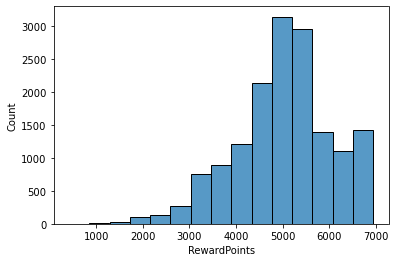

In [9]:
sns.histplot(data=data, x='RewardPoints', bins = 15)

In [10]:
pt = PowerTransformer()
print(pt.fit(data["RewardPoints"].values.reshape(-1, 1)))
PowerTransformer()
print(pt.lambdas_)
print(pt.transform(data["RewardPoints"].values.reshape(-1, 1)))


PowerTransformer()
[1.64085728]
[[-0.18403753]
 [ 1.81745736]
 [-0.70077981]
 ...
 [-0.98652552]
 [ 0.06514977]
 [ 0.04578109]]


<AxesSubplot:xlabel='RewardPoints', ylabel='Count'>

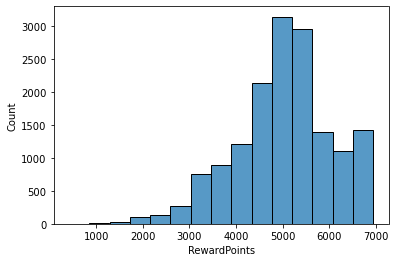

In [11]:
sns.histplot(data=data, x='RewardPoints', bins = 15)

<h3>Use KNN inputer for the missing values in Year_Birth <h3>

In [12]:
# creating an object for KNNImputer
imputer = KNNImputer(n_neighbors=5)

imputer.fit(data['Year_Birth'].values.reshape(-1, 1))
data['Year_Birth'] = imputer.transform(data['Year_Birth'].values.reshape(-1, 1))

In [13]:
data.head(28)
#the last value was missing and we obtained it with the help of KNN imputer

,Cust_ID,Churn,Name,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1,churn,Ms. Nicole Clarke,yes,1974.000000,business,single,4907,3,4,...,4,3,4,3,3,3,3,4,3,4
1,2,nochurn,Mr. Jesse Scott,yes,1965.000000,business,single,6724,1,1,...,5,3,4,5,5,5,5,1,5,2
2,3,churn,Mr. Christopher Carter,yes,1973.000000,business,single,4365,3,3,...,1,4,4,3,3,2,3,2,3,1
3,4,nochurn,Ms. Jennifer Morgan,yes,1993.000000,leisure,double,3849,1,1,...,4,4,5,4,4,4,4,4,4,3
4,5,nochurn,Mr. Michael White,yes,1989.000000,business,single,5376,2,2,...,5,5,5,5,5,3,4,1,3,5
5,6,churn,Ms. Morgan Briggs,yes,1975.000000,business,double,5342,2,2,...,3,2,2,2,2,2,2,4,2,1
6,7,churn,Ms. Kellie Alvarez,no,1990.000000,business,double,4909,2,2,...,2,2,2,2,1,1,2,2,3,2
7,8,churn,Mr. Jorge Brown,yes,1976.000000,business,single,4037,2,3,...,2,4,4,2,2,3,2,1,2,2
8,9,churn,Mr. Jesus Soto,yes,1974.000000,business,single,3694,2,3,...,2,2,2,2,2,1,2,2,2,1
9,10,churn,Mr. Anthony Young,yes,1994.000000,business,single,3475,3,5,...,3,3,3,3,4,3,4,1,4,3


In [14]:
data.isna().sum()

Cust_ID              0
Churn                0
Name                 0
Longevity            0
Year_Birth           0
TypeTravel           0
RoomType             0
RewardPoints         0
Comfort              0
ReceptionSchedule    0
FoodDrink            0
Location             0
Wifi                 0
Amenities            0
Staff                0
OnlineBooking        0
PriceQuality         0
RoomSpace            0
CheckOut             0
Checkin              0
Cleanliness          0
BarService           0
dtype: int64

<p> As demonstrated above, our data frame no longer has missing values. They have been imputed as the means of k-Nearest Neighbor values. </p>

Replacing the data from longevity to 1 and 0
Yes=1 No=0

In [15]:
data['Longevity'].value_counts()

yes    12548
no      2874
y        167
Name: Longevity, dtype: int64

In [16]:
data['Longevity'].replace(to_replace = 'yes',value = 1, inplace = True)
data['Longevity'].replace(to_replace = 'y',value = 1, inplace = True)
data['Longevity'].replace(to_replace = 'no',value = 0, inplace = True)
data['Longevity'].value_counts()

1    12715
0     2874
Name: Longevity, dtype: int64

<h3>Changing the Values of Column "TypeTravel"<h3>
 <p>business = 1 leisure = 0 <p>

In [17]:
data['TypeTravel'].value_counts()

business    10756
leisure      4833
Name: TypeTravel, dtype: int64

In [18]:
data['TypeTravel'].replace(to_replace = 'business',value = 1, inplace = True)
data['TypeTravel'].replace(to_replace = 'leisure',value = 0, inplace = True)
data['TypeTravel'].value_counts()

1    10756
0     4833
Name: TypeTravel, dtype: int64

<h3>Changing the Values of Column "Wifi"<h3>
 <p>6 were Replaced by 5 <p>

<AxesSubplot:xlabel='Wifi'>

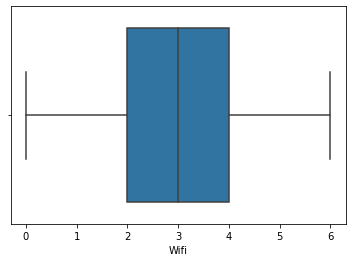

In [19]:
sns.boxplot(x="Wifi", data = data[['Wifi']])

In [20]:
data['Wifi'].value_counts()

4    3704
5    3446
3    3348
2    3245
1    1792
6      36
0      18
Name: Wifi, dtype: int64

In [21]:
data['Wifi'].replace(to_replace = 6,value = 5, inplace = True)
data['Wifi'].value_counts()

4    3704
5    3482
3    3348
2    3245
1    1792
0      18
Name: Wifi, dtype: int64

<h3>Changing the Values of Column "Churn"<h3>
 <p>convert "churn" and "nochurn" to 1 (True) and 0 (False) <p>

In [22]:
data['Churn'].value_counts()

nochurn    8477
churn      7112
Name: Churn, dtype: int64

In [23]:
data['Churn'].replace(to_replace = 'churn',value = 1, inplace = True)
data['Churn'].replace(to_replace = 'nochurn',value = 0, inplace = True)
data['Churn'].value_counts()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15589 entries, 0 to 15588
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cust_ID            15589 non-null  int64  
 1   Churn              15589 non-null  int64  
 2   Name               15589 non-null  object 
 3   Longevity          15589 non-null  int64  
 4   Year_Birth         15589 non-null  float64
 5   TypeTravel         15589 non-null  int64  
 6   RoomType           15589 non-null  object 
 7   RewardPoints       15589 non-null  int64  
 8   Comfort            15589 non-null  int64  
 9   ReceptionSchedule  15589 non-null  int64  
 10  FoodDrink          15589 non-null  int64  
 11  Location           15589 non-null  int64  
 12  Wifi               15589 non-null  int64  
 13  Amenities          15589 non-null  int64  
 14  Staff              15589 non-null  int64  
 15  OnlineBooking      15589 non-null  int64  
 16  PriceQuality       155

Change type of Year_birth to int32

In [24]:
data['Year_Birth']=data['Year_Birth'].astype(int)
data.head(4)


,Cust_ID,Churn,Name,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1,1,Ms. Nicole Clarke,1,1974,1,single,4907,3,4,...,4,3,4,3,3,3,3,4,3,4
1,2,0,Mr. Jesse Scott,1,1965,1,single,6724,1,1,...,5,3,4,5,5,5,5,1,5,2
2,3,1,Mr. Christopher Carter,1,1973,1,single,4365,3,3,...,1,4,4,3,3,2,3,2,3,1
3,4,0,Ms. Jennifer Morgan,1,1993,0,double,3849,1,1,...,4,4,5,4,4,4,4,4,4,3


<h2>Room Type change</h2>

In [25]:
data['RoomType'].value_counts()

single    7442
double    7021
suite     1126
Name: RoomType, dtype: int64

<h3>Ordinal Encoding for column RoomType<h3>

In [26]:
data['RoomType'].replace(to_replace = 'suite',value = 2, inplace = True)
data['RoomType'].replace(to_replace = 'double',value = 1, inplace = True)
data['RoomType'].replace(to_replace = 'single',value = 0, inplace = True)
data['RoomType'].value_counts()

0    7442
1    7021
2    1126
Name: RoomType, dtype: int64

<h3> Drop Column Name<h3>

In [27]:
data.drop(['Name'], axis=1, inplace=True)

<h2>MinMax Normalization<h2>

<p>Since variables that are measured at different scales do not contribute equally to the model fitting and model learned function and might end up creating a bias, we will deal with this potential problem by applying a MinMax Normalization.</p>

In [28]:
data[['Year_Birth','RewardPoints']] = minmax_scale(data[['Year_Birth','RewardPoints']])
data.head()

,Cust_ID,Churn,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,FoodDrink,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1,1,1,0.487179,1,0,0.687662,3,4,1,...,4,3,4,3,3,3,3,4,3,4
1,2,0,1,0.371795,1,0,0.965449,1,1,1,...,5,3,4,5,5,5,5,1,5,2
2,3,1,1,0.474359,1,0,0.604800,3,3,3,...,1,4,4,3,3,2,3,2,3,1
3,4,0,1,0.730769,0,1,0.525913,1,1,1,...,4,4,5,4,4,4,4,4,4,3
4,5,0,1,0.679487,1,0,0.759364,2,2,3,...,5,5,5,5,5,3,4,1,3,5


<h3>Pearson Correlation Heatmap<h3>

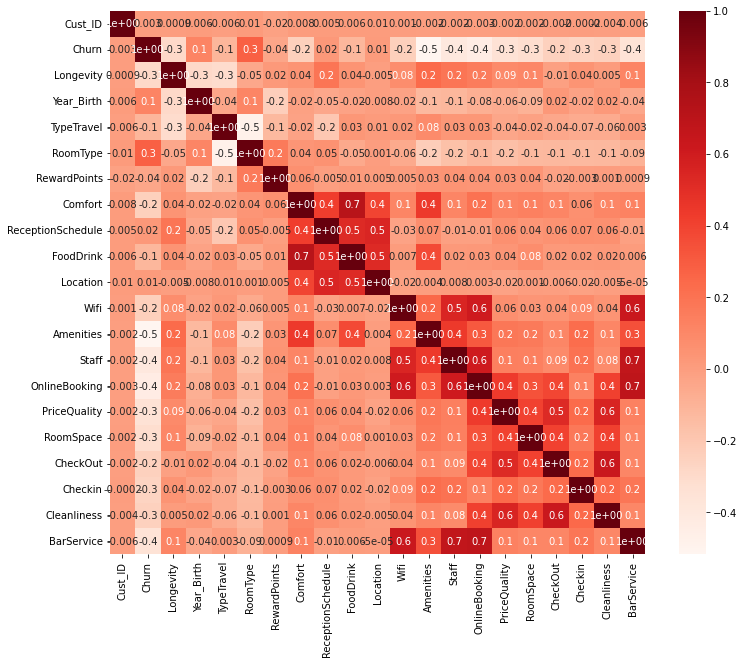

In [29]:
#pearson correlation
cor_pearson = data.corr(method ='pearson')
#Heatmap function defined
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
#print correlation
cor_heatmap(cor_pearson)

In [30]:
data.head()

,Cust_ID,Churn,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,FoodDrink,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1,1,1,0.487179,1,0,0.687662,3,4,1,...,4,3,4,3,3,3,3,4,3,4
1,2,0,1,0.371795,1,0,0.965449,1,1,1,...,5,3,4,5,5,5,5,1,5,2
2,3,1,1,0.474359,1,0,0.604800,3,3,3,...,1,4,4,3,3,2,3,2,3,1
3,4,0,1,0.730769,0,1,0.525913,1,1,1,...,4,4,5,4,4,4,4,4,4,3
4,5,0,1,0.679487,1,0,0.759364,2,2,3,...,5,5,5,5,5,3,4,1,3,5


<h3>Scale the data<h3>

<p>Since variables that are measured at different scales do not contribute equally to the model fitting and model learned function and might end up creating a bias, we will deal with this potential problem by applying a MinMax Normalization.</p>

In [31]:
from sklearn.preprocessing import MinMaxScaler

X_train = data.drop('Churn', axis = 1)
y_train = data['Churn']

scaler = MinMaxScaler().fit(X_train)
minmax_train = scaler.transform(X_train)

X_train = pd.DataFrame(minmax_train, columns = X_train.columns)
X_train.head()

,Cust_ID,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,FoodDrink,Location,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,0.000000,1.0,0.487179,1.0,0.0,0.687662,0.6,0.8,0.2,0.75,0.8,0.6,0.75,0.6,0.50,0.6,0.50,0.75,0.50,0.8
1,0.000064,1.0,0.371795,1.0,0.0,0.965449,0.2,0.2,0.2,0.00,1.0,0.6,0.75,1.0,1.00,1.0,1.00,0.00,1.00,0.4
2,0.000128,1.0,0.474359,1.0,0.0,0.604800,0.6,0.6,0.6,0.50,0.2,0.8,0.75,0.6,0.50,0.4,0.50,0.25,0.50,0.2
3,0.000192,1.0,0.730769,0.0,0.5,0.525913,0.2,0.2,0.2,0.00,0.8,0.8,1.00,0.8,0.75,0.8,0.75,0.75,0.75,0.6
4,0.000257,1.0,0.679487,1.0,0.0,0.759364,0.4,0.4,0.6,0.25,1.0,1.0,1.00,1.0,1.00,0.6,0.75,0.00,0.50,1.0


<h2>Logistic Regression.<h2>

In [36]:
from sklearn.linear_model import LogisticRegression

# Create the model
log_reg = LogisticRegression(class_weight='balanced')
# Fit the model
log_reg.fit(X_train, y_train)

labels_train = log_reg.predict(X_train)

log_reg.predict_proba(X_train)


array([[0.69041403, 0.30958597],
       [0.81468946, 0.18531054],
       [0.49221373, 0.50778627],
       ...,
       [0.93000946, 0.06999054],
       [0.7535857 , 0.2464143 ],
       [0.40578398, 0.59421602]])

In [37]:
from sklearn.metrics import f1_score

print('Train:', f1_score(y_train, labels_train))

Train: 0.8159857660986793


In [38]:
from sklearn.metrics import classification_report

print('----------------------- TRAIN -----------------------')
print(classification_report(y_train, labels_train))

----------------------- TRAIN -----------------------
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      8477
           1       0.79      0.84      0.82      7112

    accuracy                           0.83     15589
   macro avg       0.83      0.83      0.83     15589
weighted avg       0.83      0.83      0.83     15589



<h1>VALIDATION<h1>

<h2>Data preparation<h2>

In [32]:
#get the validation data
filename1 = 'validation.csv'
file_path1 = Path(filename1)
v = pd.read_csv(file_path1, delimiter=";")
validate = v.copy()
#Longevity
validate['Longevity'].replace(to_replace = 'yes',value = 1, inplace = True)
validate['Longevity'].replace(to_replace = 'y',value = 1, inplace = True)
validate['Longevity'].replace(to_replace = 'no',value = 0, inplace = True)
#TypeTravel
validate['TypeTravel'].replace(to_replace = 'business',value = 1, inplace = True)
validate['TypeTravel'].replace(to_replace = 'leisure',value = 0, inplace = True)
#Churn
validate['Churn'].replace(to_replace = 'churn',value = 1, inplace = True)
validate['Churn'].replace(to_replace = 'nochurn',value = 0, inplace = True)
#RoomType
validate['RoomType'].replace(to_replace = 'suite',value = 2, inplace = True)
validate['RoomType'].replace(to_replace = 'double',value = 1, inplace = True)
validate['RoomType'].replace(to_replace = 'single',value = 0, inplace = True)
validate.head(2)

,Cust_ID,Churn,Name,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,20000,0,Mr. Dennis Woods,0,2001,1,0,4512,5,0,...,4,5,4,4,3,2,4,3,4,4
1,20001,0,Mr. Hunter Burke,1,1965,1,0,5696,1,1,...,4,4,4,5,5,5,5,5,5,5


<h2>Checking Missing values<h2>

In [33]:
validate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Cust_ID            5195 non-null   int64 
 1   Churn              5195 non-null   int64 
 2   Name               5195 non-null   object
 3   Longevity          5195 non-null   int64 
 4   Year_Birth         5195 non-null   int64 
 5   TypeTravel         5195 non-null   int64 
 6   RoomType           5195 non-null   int64 
 7   RewardPoints       5195 non-null   int64 
 8   Comfort            5195 non-null   int64 
 9   ReceptionSchedule  5195 non-null   int64 
 10  FoodDrink          5195 non-null   int64 
 11  Location           5195 non-null   int64 
 12  Wifi               5195 non-null   int64 
 13  Amenities          5195 non-null   int64 
 14  Staff              5195 non-null   int64 
 15  OnlineBooking      5195 non-null   int64 
 16  PriceQuality       5195 non-null   int64 


<h2>Scaling<h2>

In [34]:
#Drop name column
validate.drop(['Name'], axis=1, inplace=True)
#Scaling
from sklearn.preprocessing import MinMaxScaler

X_validate = validate.drop('Churn', axis = 1)
y_validate = validate['Churn']

scaler_validate = MinMaxScaler().fit(X_validate)
minmax_validate = scaler_validate.transform(X_validate)

X_validate = pd.DataFrame(minmax_validate, columns = X_validate.columns)
X_validate.head()

,Cust_ID,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,FoodDrink,Location,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,0.000000,0.0,0.821918,1.0,0.0,0.635248,1.0,0.0,1.0,0.50,0.8,1.0,0.75,0.75,0.50,0.4,0.75,0.50,0.75,0.75
1,0.000193,1.0,0.328767,1.0,0.0,0.812388,0.2,0.2,0.2,0.00,0.8,0.8,0.75,1.00,1.00,1.0,1.00,1.00,1.00,1.00
2,0.000385,1.0,0.726027,0.0,0.5,0.630461,1.0,1.0,1.0,1.00,0.6,0.2,0.00,1.00,1.00,1.0,0.75,1.00,1.00,1.00
3,0.000578,1.0,0.575342,1.0,0.0,0.556703,0.4,0.6,0.2,0.50,0.8,0.8,0.75,0.25,0.25,0.4,0.25,0.75,0.25,0.75
4,0.000770,1.0,0.301370,1.0,0.0,0.815530,0.8,0.8,0.8,0.75,0.8,1.0,0.75,0.50,0.50,0.8,0.50,0.75,0.50,0.50


<h1>TEST<h1>

<h2>Data Preparation<h2>

In [35]:
#get the test data
filename2 = 'test.csv'
file_path2 = Path(filename2)
t = pd.read_csv(file_path2, delimiter=";")
test = t.copy()
#Longevity
test['Longevity'].replace(to_replace = 'yes',value = 1, inplace = True)
test['Longevity'].replace(to_replace = 'y',value = 1, inplace = True)
test['Longevity'].replace(to_replace = 'no',value = 0, inplace = True)
#TypeTravel
test['TypeTravel'].replace(to_replace = 'business',value = 1, inplace = True)
test['TypeTravel'].replace(to_replace = 'leisure',value = 0, inplace = True)
test.head(2)

,Cust_ID,Name,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,FoodDrink,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,30000,Mr. Brandon Aguirre,1,1956,0,double,5584,2,4,2,...,1,2,1,1,5,3,4,4,4,1
1,30001,Mr. Mathew Howard,1,2004,0,double,5970,2,4,2,...,4,2,4,4,4,5,4,3,1,4
